In [1]:
import numpy as np
import pandas as pd

from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.preprocessing import robust_scale, minmax_scale

import geopandas as gpd
from libpysal.weights import KNN

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

/home/dmitri/.local/lib/python3.11/site-packages/libpysal/cg/alpha_shapes.py:38: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
/home/dmitri/.local/lib/python3.11/site-packages/libpysal/cg/alpha_shapes.py:164: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
/home/dmitri/.local/lib/python3.11/site-packages/libpysal/cg/alpha_shapes.py:198: NumbaDeprecationW

In [2]:
KNeighbors = 5
KClustersMax = 9

Read the data

In [3]:
ThailandMap = gpd.read_file("../../../Data/Enriched/ThailandMapProvinceIdRegion/ThailandMapProvinceIdRegion.shp")
ThailandMap = ThailandMap.rename(columns={'RegionInTh':'RegionInThai'})

ThailandMap['Region'] = ThailandMap['Region'].replace(
    {
        'NorthernThailand': 'Northern Thailand'
        , 'SouthernThailand': 'Southern Thailand'
        , 'WesternThailand': 'Western Thailand'
        , 'EasternThailand': 'Eastern Thailand'
        , 'NortheastThailand': 'Northeast Thailand'
        , 'CentralThailand': 'Central Thailand'
    }
)

ThailandMap = ThailandMap.sort_values('ProvinceId').reset_index(drop=True)

ThailandMapWithoutBkk = ThailandMap[ThailandMap['Name']!='Bangkok'].reset_index(drop=True)
ThailandMap = pd.concat([ThailandMapWithoutBkk, ThailandMap[ThailandMap['Name']=='Bangkok']]).reset_index(drop=True)

In [4]:
Dat = pd.read_csv("../../../Data/Processed/DataProvince.csv")
Dat = Dat.sort_values('ProvinceId').reset_index(drop=True)

Dat['MonthlyIncomeRatio2020'] = Dat['MonthlyIncomeQuantile80'] / Dat['MonthlyIncomeQuantile20']

Select the variables used in the PCA

In [5]:
Variables = [
    'MonthlyIncomeMean', 'MonthlyIncomeGiniIndex'
    , 'MonthlyIncomeRatio2020', 'IndicatorFormalDebtMean'
    , 'YearlySavingsPositiveMean', 'YearsOfEducation'
    , 'Indicator25Mean', 'Indicator23Mean', 'Indicator24Mean'
]

In [6]:
RenameVariables = {
    'MonthlyIncomeMean': "Monthly Income"
    , 'MonthlyIncomeGiniIndex': "Gini Index"
    , 'MonthlyIncomeRatio2020': "Income Ratio 20:20"
    , 'IndicatorFormalDebtMean': "Percent Formal Debt"
    , 'YearlySavingsPositiveMean': "Yearly Savings"
    , 'YearsOfEducation': "Years Of Education"
    , 'Indicator25Mean': "Smoking"
    , 'Indicator23Mean': "Having No Savings"
    , 'Indicator24Mean': "Alcohol Consumption"
}

In [7]:
DatVariables = Dat[Variables]
DatVariables = DatVariables.rename(columns=RenameVariables)

DatScaled = robust_scale(DatVariables)
DatScaled = pd.DataFrame(DatScaled, columns=DatVariables.columns)

DatVariables['ProvinceId'] = Dat['ProvinceId']

---

Agglomerative hierarchical clustering

In [8]:
WeightKnn = KNN.from_dataframe(ThailandMapWithoutBkk, k=KNeighbors)

In [9]:
for k in range(2, KClustersMax+1):
    Dendogram = AgglomerativeClustering(linkage="ward", connectivity=WeightKnn.sparse, n_clusters=k)
    Dendogram.fit(DatScaled)

    DatVariables['RegionHierar_' + str(k)] = Dendogram.labels_

In [10]:
ThailandMap = pd.merge(
    ThailandMap
    , DatVariables[['ProvinceId'] + [col for col in DatVariables if col.startswith('Region')]]
    , how='left'
)

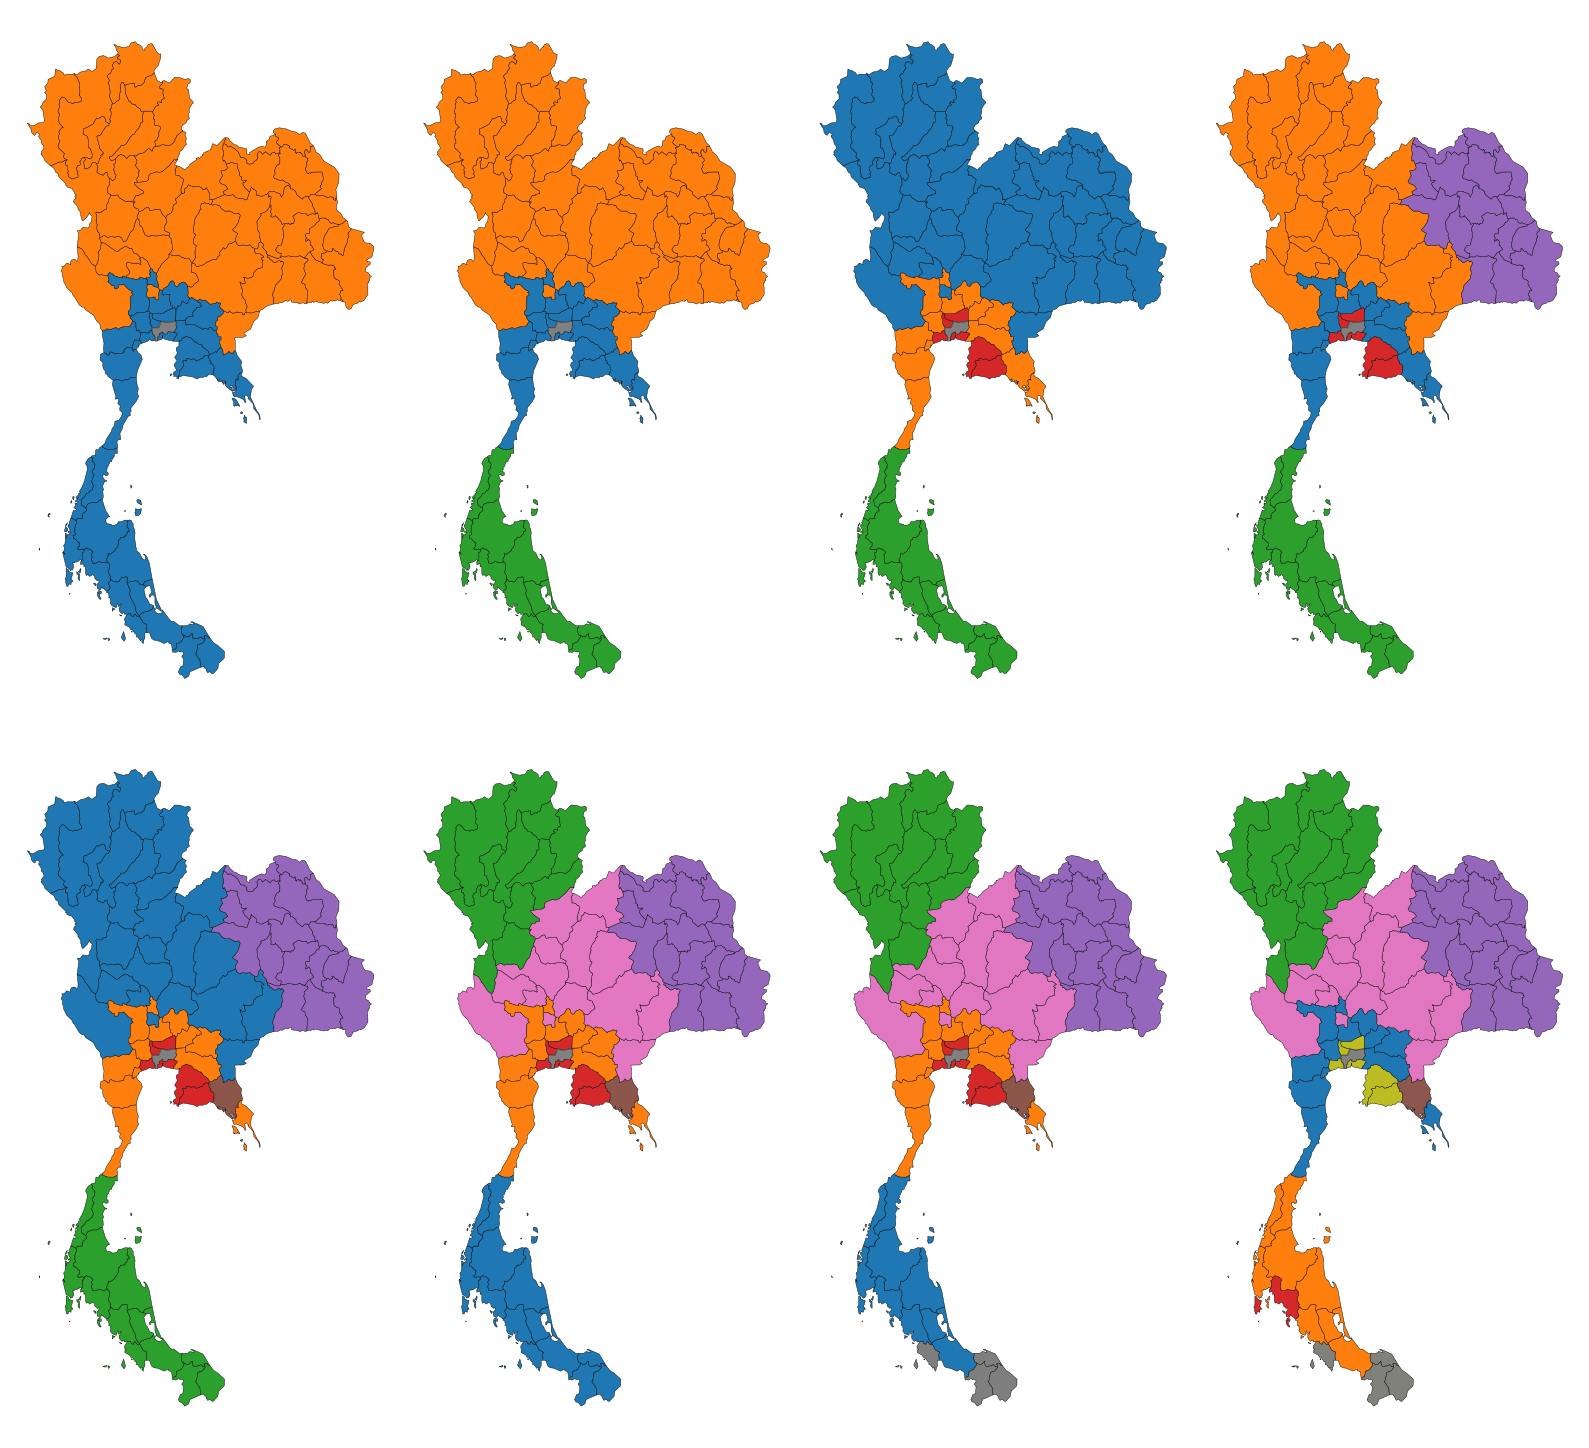

In [11]:
f, axs = plt.subplots(2, 4, figsize=(16, 15), subplot_kw=dict(aspect="equal"))

for i, ax in enumerate(axs.flat):
    ThailandMap.plot(
        'RegionHierar_' + str(i+2)
        , categorical = True
        , cmap = LinearSegmentedColormap.from_list('my_cmap', colors=plt.colormaps["tab10"].colors[:(i+2)])
        , ax = ax
        , edgecolor = 'k'
        , linewidth = 0.3
        , legend = False
        , missing_kwds={'color':'grey', 'label':'BKK: No data'}
        , legend_kwds={'loc':'lower right'}
    ).set_axis_off()

f.tight_layout()

Geographical coherence

In [12]:
ThailandMapWithoutBkk = pd.merge(
    ThailandMapWithoutBkk
    , DatVariables[['ProvinceId'] + [col for col in DatVariables if col.startswith('Region')]]
    , how='left'
    , on='ProvinceId'
)

ThailandMapWithoutBkk['geometry'] = ThailandMapWithoutBkk.geometry.buffer(0)

results = []
for cluster_type in [col for col in DatVariables if col.startswith('Region')]:
    # compute the region polygons using a dissolve
    regions = ThailandMapWithoutBkk[[cluster_type, "geometry"]].dissolve(by=cluster_type)
    # compute the actual isoperimetric quotient for these regions
    ipqs = (
        regions.area * 4 * np.pi / (regions.boundary.length ** 2)
    )
    ipqs = ipqs.sort_values().reset_index(drop=True)
    # cast to a dataframe
    result = ipqs.to_frame(cluster_type)
    results.append(result)

# stack the series together along columns
Ipq = pd.concat(results, axis=1)

IpqMean = Ipq.mean().to_list()

/tmp/ipykernel_11664/1898202083.py:16: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  regions.area * 4 * np.pi / (regions.boundary.length ** 2)
/tmp/ipykernel_11664/1898202083.py:16: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  regions.area * 4 * np.pi / (regions.boundary.length ** 2)
/tmp/ipykernel_11664/1898202083.py:16: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  regions.area * 4 * np.pi / (regions.boundary.length ** 2)
/tmp/ipykernel_11664/1898202083.py:16: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to r

Calinski-Harabasz score

In [13]:
ch_scores = []
for cluster_type in [col for col in DatVariables if col.startswith('Region')]:
    ch_score = calinski_harabasz_score(DatScaled, DatVariables[cluster_type],)
    ch_scores.append((cluster_type, ch_score))

CHScores = pd.DataFrame(
    ch_scores, columns=["cluster type", "CH score"]
)

Silhoutte score

In [14]:
sil_scores = []
for cluster_type in [col for col in DatVariables if col.startswith('Region')]:
    sil_score = silhouette_score(DatScaled, DatVariables[cluster_type],)
    sil_scores.append((cluster_type, sil_score))

SilScores = pd.DataFrame(
    sil_scores, columns=["cluster type", "Silhoutte score"]
)

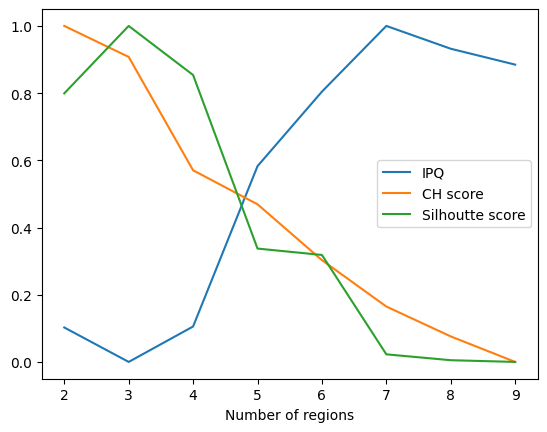

In [15]:
f = plt.figure()

plt.plot(range(2, KClustersMax+1), minmax_scale(IpqMean), label='IPQ')
plt.plot(range(2, KClustersMax+1), minmax_scale(CHScores['CH score']), label='CH score')
plt.plot(range(2, KClustersMax+1), minmax_scale(SilScores['Silhoutte score']), label='Silhoutte score')

plt.xlabel("Number of regions")
plt.legend()

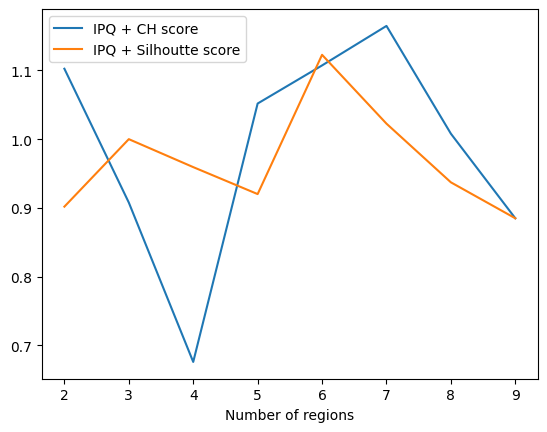

In [16]:
f = plt.figure()

plt.plot(range(2, KClustersMax+1), minmax_scale(IpqMean) + minmax_scale(CHScores['CH score']), label='IPQ + CH score')
plt.plot(range(2, KClustersMax+1), minmax_scale(IpqMean) + minmax_scale(SilScores['Silhoutte score']), label='IPQ + Silhoutte score')

plt.xlabel("Number of regions")
plt.legend()